<a href="https://colab.research.google.com/github/rufous86/hh_api/blob/main/hh_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

[**hh api**](https://github.com/hhru/api)

</center>

In [ ]:
# ! pip install geopy

In [ ]:
import requests
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import plotly.express as px

In [82]:
res = []
def get_vacancy(vacancies, pages=100):
    for vacancy in tqdm(vacancies):
        print(f'collecting <{vacancy}>')
        for page in tqdm(range(pages)):
            params = {
                'text': f'NAME:{vacancy}',
                'page': page,
                'per_page': 100,
                'currency': 'RUR',
                'only_with_salary': 'true',
                }
            req = requests.get('https://api.hh.ru/vacancies', params).json()
            if 'items' in req.keys():
                res.extend(req['items'])

vacancies = ['maching learning', 'данные', 'data', 'sql', 'NLP',
             'spark', 'hadoop', 'pandas', 'dask', 'deep learning', 'pytorch',
             'tensorflow', 'keras', 'аналитик', 'ai AND developer']
get_vacancy(vacancies)

data = pd.DataFrame(res)
data.shape

  0%|          | 0/15 [00:00<?, ?it/s]

collecting <maching learning>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <данные>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <data>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <sql>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <NLP>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <spark>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <hadoop>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <pandas>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <dask>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <deep learning>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <pytorch>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <tensorflow>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <keras>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <аналитик>


  0%|          | 0/100 [00:00<?, ?it/s]

collecting <ai AND developer>


  0%|          | 0/100 [00:00<?, ?it/s]

(2244, 30)

In [83]:
df = data.copy()
columns = ['name', 'salary', 'schedule', 'accept_temporary', 'area']
df = df[columns]
df.head()

,name,salary,schedule,accept_temporary,area
0,Senior Machine Learning Engineer,"{'from': 4000, 'to': 5800, 'currency': 'EUR', ...","{'id': 'fullDay', 'name': 'Полный день'}",True,"{'id': '1', 'name': 'Москва', 'url': 'https://..."
1,Machine learning engineer/ разработчик машинно...,"{'from': 200000, 'to': 400000, 'currency': 'RU...","{'id': 'remote', 'name': 'Удаленная работа'}",False,"{'id': '72', 'name': 'Пермь', 'url': 'https://..."
2,Senior Machine Learning Engineer (NLP/Speech),"{'from': 314000, 'to': 314000, 'currency': 'RU...","{'id': 'fullDay', 'name': 'Полный день'}",False,"{'id': '237', 'name': 'Сочи', 'url': 'https://..."
3,Machine Learning Engineer,"{'from': 4000, 'to': 8000, 'currency': 'USD', ...","{'id': 'remote', 'name': 'Удаленная работа'}",True,"{'id': '2758', 'name': 'Тбилиси', 'url': 'http..."
4,Senior Machine Learning Engineer (Golang/Pytho...,"{'from': 380000, 'to': None, 'currency': 'RUR'...","{'id': 'flexible', 'name': 'Гибкий график'}",False,"{'id': '1', 'name': 'Москва', 'url': 'https://..."


In [84]:
df["city"] = (df["area"]
                     .apply(lambda x: x.get("name") 
                                      if isinstance(x, dict) 
                                      else np.nan))
df["schedule"] = (df["schedule"]
                     .apply(lambda x: x.get("id") 
                                      if isinstance(x, dict) 
                                      else np.nan))
df["salary_from"] = (df["salary"]
                     .apply(lambda x: x.get("from") 
                                      if isinstance(x, dict) 
                                      else np.nan))
df["salary_to"] = (df["salary"]
                     .apply(lambda x: x.get("to") 
                                      if isinstance(x, dict) 
                                      else np.nan))
df["salary_currency"] = (df["salary"]
                     .apply(lambda x: x.get("currency") 
                                      if isinstance(x, dict) 
                                      else np.nan))

df = df.drop(['salary', 'area'], axis=1)
df.head()

,name,schedule,accept_temporary,city,salary_from,salary_to,salary_currency
0,Senior Machine Learning Engineer,fullDay,True,Москва,4000.0,5800.0,EUR
1,Machine learning engineer/ разработчик машинно...,remote,False,Пермь,200000.0,400000.0,RUR
2,Senior Machine Learning Engineer (NLP/Speech),fullDay,False,Сочи,314000.0,314000.0,RUR
3,Machine Learning Engineer,remote,True,Тбилиси,4000.0,8000.0,USD
4,Senior Machine Learning Engineer (Golang/Pytho...,flexible,False,Москва,380000.0,NaN,RUR


In [85]:
df = df[df['salary_currency'] == 'RUR']

In [86]:
df = df.drop_duplicates()

In [87]:
df['salary_currency'].value_counts()

RUR    1968
Name: salary_currency, dtype: int64

In [90]:
df['salary_from'] = df['salary_from'].fillna(df['salary_to'])
df['salary_to'] = df['salary_to'].fillna(df['salary_from'])

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968 entries, 1 to 2243
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1968 non-null   object 
 1   schedule          1968 non-null   object 
 2   accept_temporary  1968 non-null   bool   
 3   city              1968 non-null   object 
 4   salary_from       1968 non-null   float64
 5   salary_to         1968 non-null   float64
 6   salary_currency   1968 non-null   object 
dtypes: bool(1), float64(2), object(4)
memory usage: 109.5+ KB


In [92]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geo")

def get_coords(city):
    geo = geolocator.geocode(city)
    if geo:
        return geo.longitude, geo.latitude
    else:
        return np.nan, np.nan


coords = pd.DataFrame(data=df['city'].unique(), columns=['city'])
coords['(lon, lat)'] = (coords['city']
                        .apply(lambda x: get_coords(x)))


coords['lon'] = (coords['(lon, lat)']
                        .apply(lambda x: x[0]))
coords['lat'] = (coords['(lon, lat)']
                        .apply(lambda x: x[1]))
coords = coords.drop('(lon, lat)', axis=1)

In [93]:
total_vac = dict(df
            .groupby('city')['name']
            .agg('count')
            )

In [94]:
df = df.merge(coords, on='city')
df['salary_mean'] = (df['salary_from'] + df['salary_to']) / 2
df['total_vac'] = (df['city']
                .apply(lambda x: total_vac[x]))
df.head()

,name,schedule,accept_temporary,city,salary_from,salary_to,salary_currency,lon,lat,salary_mean,total_vac
0,Machine learning engineer/ разработчик машинно...,remote,False,Пермь,200000.0,400000.0,RUR,56.230767,58.021487,300000.0,25
1,Разработчик PL/SQL,fullDay,False,Пермь,80000.0,80000.0,RUR,56.230767,58.021487,80000.0,25
2,Системный аналитик (Удалённая работа),fullDay,True,Пермь,120000.0,120000.0,RUR,56.230767,58.021487,120000.0,25
3,Бизнес-аналитик,fullDay,False,Пермь,80000.0,80000.0,RUR,56.230767,58.021487,80000.0,25
4,Системный аналитик IT,remote,True,Пермь,80000.0,150000.0,RUR,56.230767,58.021487,115000.0,25


In [95]:
df_grouped = (df
     .groupby('city')[['salary_mean', 'lon', 'lat', 'total_vac']]
     .agg('mean')
                         )

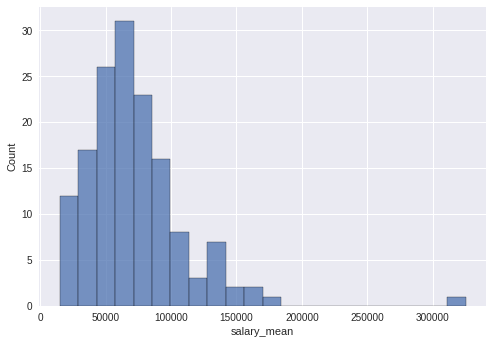

In [96]:
sns.histplot(data=df_grouped, x='salary_mean')

Число выбросов по методу z-отклонения: 1
Результирующее число записей: 148


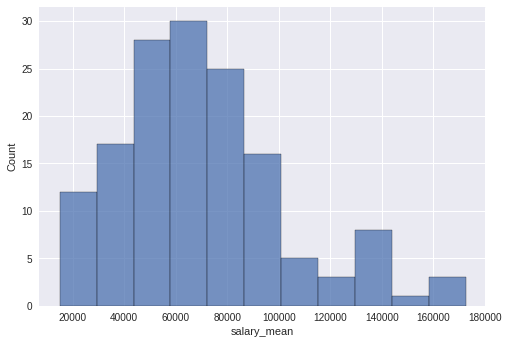

In [97]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
    print(f'Результирующее число записей: {cleaned.shape[0]}')
    return cleaned

df_grouped = outliers_z_score(df_grouped, 'salary_mean')

sns.histplot(data=df_grouped, x='salary_mean')
plt.show()

In [98]:
df_grouped['city'] = df_grouped.index

In [100]:
fig = px.scatter_geo(df_grouped, lat='lat', lon='lon', 
                     color='salary_mean', text='city', 
                     color_continuous_scale=px.colors.sequential.Jet, 
                     size='total_vac', size_max=40, width=1000, height=900)
fig.show()

In [101]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df_grouped[['total_vac', 'salary_mean']]
scaler = StandardScaler().fit_transform(X)
clustering = KMeans(n_clusters=5).fit(scaler)
clustering.labels_

array([4, 1, 2, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 4, 2, 2, 1, 1, 4, 1, 4, 2,
       2, 4, 4, 1, 4, 1, 1, 1, 1, 1, 2, 0, 1, 0, 4, 0, 1, 1, 2, 1, 1, 1,
       2, 1, 2, 1, 1, 4, 1, 4, 4, 2, 2, 0, 1, 1, 4, 2, 2, 2, 2, 4, 0, 1,
       4, 1, 2, 2, 4, 2, 1, 1, 1, 1, 3, 0, 1, 4, 2, 4, 4, 1, 2, 4, 0, 1,
       1, 4, 1, 4, 4, 4, 4, 1, 2, 2, 4, 4, 4, 2, 4, 4, 2, 2, 1, 2, 2, 1,
       1, 4, 0, 0, 0, 1, 1, 0, 2, 2, 4, 1, 1, 1, 1, 4, 2, 2, 2, 2, 2, 1,
       4, 2, 1, 4, 1, 1, 1, 2, 2, 1, 4, 0, 4, 4, 1, 0], dtype=int32)

In [102]:
df_grouped['cluster'] = clustering.labels_

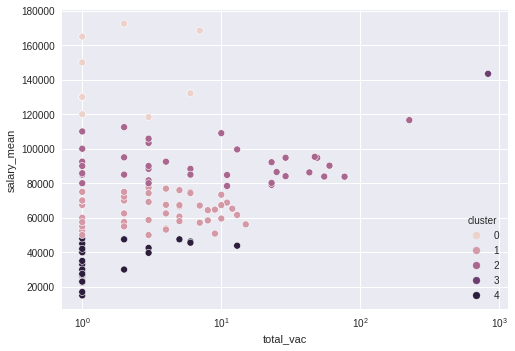

In [103]:
sns.scatterplot(data=df_grouped, x='total_vac', y='salary_mean', hue='cluster')
plt.xscale('log')
plt.show()

In [104]:
fig = px.scatter_geo(df_grouped, lat='lat', lon='lon', 
                     color='cluster',  hover_name='city', 
                     labels='salary_mean',
                     color_continuous_scale=px.colors.sequential.Jet, 
                     size_max=40, width=1000, height=900)
fig.show()

In [ ]:
fig.write_html('scatter_geo.html')